In [1]:
%matplotlib inline
import numpy as np
import cv2
import os

import time
from tqdm import tqdm



import matplotlib.pyplot as plt

import pywt

import re

In [2]:
import numpy as np
import astra

def reconstruct_volume(projections, num_slices, num_rows, num_cols, num_projections):
    # Geometric parameters
    origin_det = 1040 - 570
    source_origin = 570
    angles = np.linspace(0, 2 * np.pi, num_projections, endpoint=False)

    # Create projection geometry
    

    # Create volume geometry
    FOV = (1*512)*source_origin/(2*np.sqrt((1*512)**2/4+(source_origin+origin_det)**2))
    vol_geom = astra.create_vol_geom(512, 512, 512, -FOV, FOV, -FOV, FOV, -FOV, FOV)
    proj_geom = astra.create_proj_geom('cone', 1, 1, num_rows, num_cols, angles, source_origin, origin_det)

    # Create data object for the projection data
    projections_id = astra.data3d.create('-proj3d', proj_geom, projections)

    # Set up and run the reconstruction algorithm
    cfg = astra.astra_dict('FDK_CUDA')
    cfg['ReconstructionDataId'] = astra.data3d.create('-vol', vol_geom)
    cfg['ProjectionDataId'] = projections_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 150)

    # Get the reconstructed volume
    reconstructed_volume = astra.data3d.get(cfg['ReconstructionDataId'])

    # Clean up
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(projections_id)
    astra.data3d.delete(cfg['ReconstructionDataId'])

    return reconstructed_volume

In [3]:
def calculate_mse(image_a, image_b):
    
    squared_diff = (image_a - image_b) ** 2

    mse = np.mean(squared_diff)
    return mse

In [4]:
def find_paths_with_id(root_directory, list):    
    for dirpath, dirnames, filenames in os.walk(root_directory):
        for name in dirnames + filenames:
            if 'npy' in name:
                # Construct the full path and add to list
                full_path = os.path.join(dirpath, name)
                img = np.load(full_path)
                list.append(img)
                

In [41]:
dic = './clean'
projections = []
find_paths_with_id(dic, projections)

In [42]:
dic = './scatter'
projections_ = []
find_paths_with_id(dic, projections_)

In [43]:
len(projections)

56

In [44]:
image = np.transpose(projections_[6], (1,0,2))
recon = reconstruct_volume(image, 128, 512, 512, 32)

In [45]:
image1 = np.transpose(projections[6], (1,0,2))
recon1 = reconstruct_volume(image1, 128, 512, 512, 32)

In [46]:
temp = recon1 - recon

In [51]:
recons = []

for img in tqdm(projections):
    image = np.transpose(img, (1,0,2))
    recon = reconstruct_volume(image, 128, 512, 512, 32)
    recons.append(recon)

100%|██████████| 56/56 [00:33<00:00,  1.68it/s]


In [52]:
def plot_image(index):
    plt.imshow(recons[1][index,:,:], cmap='gray')
    plt.title(f"Image {index}")
    plt.colorbar()
    plt.show()
interact(plot_image, index=(0, recon.shape[0]-1))

interactive(children=(IntSlider(value=255, description='index', max=511), Output()), _dom_classes=('widget-int…

<function __main__.plot_image(index)>

In [53]:
def wavelet(data):
    depth, height, width = data.shape
 
    final_data = np.zeros((depth, height , width))
    hh0 = np.zeros((depth, height // 2, width // 2))
    hl0 = np.zeros((depth, height // 2, width // 2))
    lh0 = np.zeros((depth, height // 2, width // 2))
    hh1 = np.zeros((depth, height // 4, width // 4))
    hl1 = np.zeros((depth, height // 4, width // 4))
    lh1 = np.zeros((depth, height // 4, width // 4))
    hh2 = np.zeros((depth, height // 8, width // 8))
    hl2 = np.zeros((depth, height // 8, width // 8))
    lh2 = np.zeros((depth, height // 8, width // 8))
    hh3 = np.zeros((depth, height // 16, width // 16))
    hl3 = np.zeros((depth, height // 16, width // 16))
    lh3 = np.zeros((depth, height // 16, width // 16))
    ll = np.zeros((depth, height // 16, width // 16))
    
    for z in range(depth):
        coeff = pywt.wavedec2(data[z], 'haar', level = 4)
        hh0[z] = coeff[4][2]
        hl0[z] = coeff[4][1]
        lh0[z] = coeff[4][0]
        hh1[z] = coeff[3][2]
        hl1[z] = coeff[3][1]
        lh1[z] = coeff[3][0]
        hh2[z] = coeff[2][2]
        hl2[z] = coeff[2][1]
        lh2[z] = coeff[2][0]
        hh3[z] = coeff[1][2]
        hl3[z] = coeff[1][1]
        lh3[z] = coeff[1][0]
        ll[z] = coeff[0]
        

    return hh0, hl0, lh0, hh1, hl1, lh1, hh2, hl2, lh2, hh3, hl3, lh3, ll

       
def re_wavelet(final_data):
    depth, height, width = final_data.shape
    
    data = np.zeros((depth, height, width))
  
    for z in range(depth):
        ll = final_data[z, 0:32, 0:32] 
        hh3 =  final_data[z, 32:64, 32:64]  
        hl3 = final_data[z, 32:64, 0:64]  
        lh3 = final_data[z, 0:64, 32:64]   

        hh2 = final_data[z, 64:128, 64:128] 
        hl2 = final_data[z, 64:128, 0:128]  
        lh2 = final_data[z, 0:128, 64:128]    

        hh1 = final_data[z, 128:256, 128:256]  
        hl1 = final_data[z, 128:256, 0:256] 
        lh1 = final_data[z, 0:256, 128:256]  

        hh0 = final_data[z, 256:512, 256:512] 
        hl0 = final_data[z, 256:512, 0:512] 
        lh0 = final_data[z, 0:512, 256:512] 

        coeff = [ll, (lh3, hl3, hh3), (lh2, hl2, hh2), (lh1, hl1, hh1), (lh0, hl0, hh0)]
        data[z] = pywt.waverec2(coeff, 'haar')

        
        
    return data

In [54]:
# original loss matrix
ori_loss = []
n = len(recons)
for i in range(n):
    for j in range(i + 1, n):
       
        mse = calculate_mse(recons[i],recons[j] )
        ori_loss.append(mse)


wl_input_ll = []
wl_input_lh1 = []
wl_input_hl1 = []
wl_input_hh1 = []

wl_input_lh2 = []
wl_input_hl2 = []
wl_input_hh2 = []

wl_input_lh3 = []
wl_input_hl3 = []
wl_input_hh3 = []

wl_input_lh4 = []
wl_input_hl4 = []
wl_input_hh4 = []

for img in projections:

    hh0, hl0, lh0, hh1, hl1, lh1, hh2, hl2, lh2, hh3, hl3, lh3, ll = wavelet(img)
    
    wl_input_lh1.append(lh1)
    wl_input_hl1.append(hl1)
    wl_input_hh1.append(hh1)
    
    wl_input_lh2.append(lh2)
    wl_input_hl2.append(hl2)
    wl_input_hh2.append(hh2)
  
    wl_input_lh3.append(lh3)
    wl_input_hl3.append(hl3)
    wl_input_hh3.append(hh3)

    wl_input_lh4.append(lh0)
    wl_input_hl4.append(hl0)
    wl_input_hh4.append(hh0)

    wl_input_ll.append(ll)

In [59]:
n = len(projections)
ll_loss = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_ll[i],wl_input_ll[j] )
        ll_loss.append(mse)

lh_loss1 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_lh1[i],wl_input_lh1[j] )
        lh_loss1.append(mse)

hl_loss1 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_hl1[i],wl_input_hl1[j] )
        hl_loss1.append(mse)

hh_loss1 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_hh1[i],wl_input_hh1[j] )
        hh_loss1.append(mse)


    
lh_loss2 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_lh2[i],wl_input_lh2[j] )
        lh_loss2.append(mse)

hl_loss2 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_hl2[i],wl_input_hl2[j] )
        hl_loss2.append(mse)

hh_loss2 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_hh2[i],wl_input_hh2[j] )
        hh_loss2.append(mse)



lh_loss3 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_lh3[i],wl_input_lh3[j] )
        lh_loss3.append(mse)

hl_loss3 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_hl3[i],wl_input_hl3[j] )
        hl_loss3.append(mse)

hh_loss3 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_hh3[i],wl_input_hh3[j] )
        hh_loss3.append(mse)

lh_loss4 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_lh4[i],wl_input_lh4[j] )
        lh_loss4.append(mse)

hl_loss4 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_hl4[i],wl_input_hl4[j] )
        hl_loss4.append(mse)

hh_loss4 = []
for i in range(n):
    for j in range(i + 1, n):
        mse = calculate_mse(wl_input_hh4[i],wl_input_hh4[j] )
        hh_loss4.append(mse)

In [60]:
hh1_loss_array = np.array(hh_loss1)
hl1_loss_array = np.array(hl_loss1)
lh1_loss_array = np.array(lh_loss1)
ll_loss_array = np.array(ll_loss)
hh1_loss_array = np.expand_dims(hh1_loss_array, 0)
hl1_loss_array = np.expand_dims(hl1_loss_array, 0)
lh1_loss_array = np.expand_dims(lh1_loss_array, 0)
ll_loss_array = np.expand_dims(ll_loss_array, 0)

hh2_loss_array = np.array(hh_loss2)
hl2_loss_array = np.array(hl_loss2)
lh2_loss_array = np.array(lh_loss2)
hh2_loss_array = np.expand_dims(hh2_loss_array, 0)
hl2_loss_array = np.expand_dims(hl2_loss_array, 0)
lh2_loss_array = np.expand_dims(lh2_loss_array, 0)
hh3_loss_array = np.array(hh_loss3)
hl3_loss_array = np.array(hl_loss3)
lh3_loss_array = np.array(lh_loss3)
hh3_loss_array = np.expand_dims(hh3_loss_array, 0)
hl3_loss_array = np.expand_dims(hl3_loss_array, 0)
lh3_loss_array = np.expand_dims(lh3_loss_array, 0)
hh4_loss_array = np.array(hh_loss4)
hl4_loss_array = np.array(hl_loss4)
lh4_loss_array = np.array(lh_loss4)
hh4_loss_array = np.expand_dims(hh4_loss_array, 0)
hl4_loss_array = np.expand_dims(hl4_loss_array, 0)
lh4_loss_array = np.expand_dims(lh4_loss_array, 0)


In [61]:
wl_loss = np.concatenate((ll_loss_array, lh1_loss_array, hl1_loss_array,hh1_loss_array,lh2_loss_array, hl2_loss_array, hh2_loss_array,lh3_loss_array, hl3_loss_array, hh3_loss_array,lh4_loss_array, hl4_loss_array, hh4_loss_array), axis=0)

In [65]:
from tqdm import tqdm
from scipy.optimize import minimize
ori_loss_array = np.array(ori_loss)
ori_loss_array = np.expand_dims(ori_loss_array, 0)
ori_loss_train = ori_loss_array

# chunk_size = 10

def objective_function(a,w,o):
    
    weighted = np.dot(a, w)
    correlation = np.corrcoef(weighted, o)
    correlation = - correlation[0, 1]
    # diff = (weighted - o)**2
    # sum = -np.sum(diff)
    
    return correlation
def sum_constraint(weights):
    return np.sum(weights) - 13
constr = {'type': 'eq', 'fun': sum_constraint}
bounds = [(0, None) for _ in range(13)]
array = np.ones((13, 1))
array = array.flatten()
solutions = []
print(wl_loss_train.shape, ori_loss_train.shape)
# for epoch in tqdm(range(600)):

result = minimize(objective_function,array, (wl_loss_train,ori_loss_train), method='SLSQP',bounds=bounds )

optimal = result.x
print(optimal)
sum = np.sum(optimal)
print(sum)
optimal = optimal/sum
print(optimal)
print(np.sum(optimal))



(13, 1540) (1, 1540)
[0.01640215 0.88642817 1.02493439 1.00049816 0.05859909 1.29073107
 1.00474506 0.03329308 4.22551831 1.08480266 0.99064101 1.00211827
 1.00003911]
13.618750518837329
[0.00120438 0.0650888  0.07525906 0.07346475 0.00430282 0.09477603
 0.0737766  0.00244465 0.3102721  0.07965508 0.07274096 0.07358372
 0.07343105]
0.9999999999999999


In [66]:
optimal

array([0.00120438, 0.0650888 , 0.07525906, 0.07346475, 0.00430282,
       0.09477603, 0.0737766 , 0.00244465, 0.3102721 , 0.07965508,
       0.07274096, 0.07358372, 0.07343105])

In [67]:
def objective_function_test(a):
    
    weighted = np.dot(a, np.array(wl_loss_train))
    # print(a.shape, wl_loss.shape,ori_loss.shape)
    correlation = np.corrcoef(weighted, np.array(ori_loss_train))
    correlation = correlation[0, 1]
    
    return correlation  

In [68]:
def reevaluate_solutions(solutions):
    best_score = 1
    best_solution = None

    for solution in solutions:
   
        
          
            score = objective_function_test(solution)  
            score = np.abs(score)

            if score < best_score:
                best_score = score
                best_solution = solution

    return best_solution, best_score

In [69]:
score = objective_function_test(optimal) 

In [70]:
score

0.9945057253614422

In [71]:
score = objective_function_test(array) 

In [72]:
score

0.9223999822275931

In [82]:
from matplotlib.colors import ListedColormap

# Get the original colormap
original_cmap = plt.cm.viridis

# Create a new colormap from the original, including alpha values for transparency
colors = original_cmap(np.arange(original_cmap.N))
colors[:, -1] = np.linspace(0, 1, original_cmap.N)  # Change alpha values

# Create a new colormap object
transparent_cmap = ListedColormap('blue')


In [83]:
cmap = plt.cm.RdBu

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap('blue')


0.9999999999999998


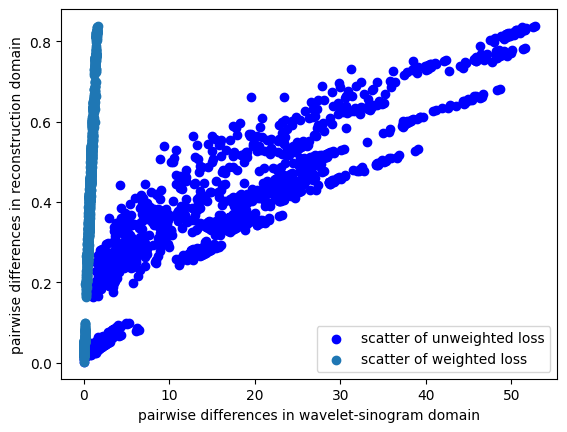

In [99]:
array = np.ones((13, 1))/13

array = array.flatten()
print(np.sum(array))
weighted = np.dot(optimal, wl_loss)
wl_loss2 = np.dot(array, wl_loss)
ori_loss = ori_loss_array *10000

plt.scatter(wl_loss2, ori_loss, color = 'blue',label='scatter of unweighted loss')
plt.scatter(weighted, ori_loss,label='scatter of weighted loss')
plt.ylabel("pairwise differences in reconstruction domain")
plt.xlabel("pairwise differences in wavelet-sinogram domain")
plt.legend()

In [ ]:
# %matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(solutions)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))  
axes = axes.flatten()  

for i in range(df.shape[1]):  
    axes[i].hist(df[i], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Dimension {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'pandas'